# VMC for bose einsten condensation, no interaction, armonic potential

In [276]:
# import numpy and exp mat
import numpy as np
from math import exp, sqrt
# import njit
from numba import njit

# import random
import random

import matplotlib.pyplot as plt

%matplotlib widget


In [277]:
D = 2
N = 100

In [278]:
@njit
def WaveFunction(R, params):
    return exp(-params[0]*np.sum(R**2))

In [279]:
# def loc energy
@njit
def LocalEnergy(R, params):
    return N*D*params[0] + (0.5 - 2*params[0]**2)*np.sum(R**2)


@njit
def Metropolis_jump(dt, subgroup_size):
    # move only a subgroup of particles
    subgroup = np.random.randint(0,N,subgroup_size)
    delta = np.zeros((N,D)) 
    delta[subgroup] = (np.random.random((subgroup_size,D))-0.5)*dt
    return delta


@njit
def MetropolisTest(WF_old, WF_new):
    WaveFuncLikehood = ( WF_new / WF_old )**2
    # true if the move is accepted
    return np.random.random() < (WaveFuncLikehood)

In [280]:
@njit
def MetropolisWalker(params, steps, dt, subgroup_size, init_conf=None):

    chain = np.zeros((steps, N, D))

    x_old = np.random.normal(0, 1, (N,D)) 
    if init_conf is not None:
        x_old = init_conf

    x_new = np.zeros((N,D))

    wf_old = WaveFunction(x_old, params)
    wf_new = 0.0

    naccept = 0 

    for i in range(steps):

        x_new = x_old + Metropolis_jump(dt, subgroup_size)
        wf_new = WaveFunction(x_new, params)

        if MetropolisTest(wf_old, wf_new):
            x_old = x_new
            wf_old = wf_new
            naccept += 1

        chain[i,:,:] = x_old
        
    return chain, naccept/steps

In [281]:
# def a function that get the autocorrelation coefficient from a time series
@njit
def AutocorrCoeff(X):
    C_tau = np.zeros(250)
    # C_tau_err is the std of the mean
    C_tau_err = np.zeros(250)

    for t in range(250):
        C_taus_temp = np.zeros(len(X)-t)    
        for i in range(len(X)-t):
            C_taus_temp[i] = X[i]*X[i+t]

        C_tau[t] = np.mean(C_taus_temp)
        C_tau_err[t] = np.std(C_taus_temp)/sqrt(len(C_taus_temp))
    
    C_tau = (C_tau - np.mean(X)**2) / np.var(X)
    C_tau_err = 0* C_tau_err / np.var(X)

    return C_tau, C_tau_err

0.40284


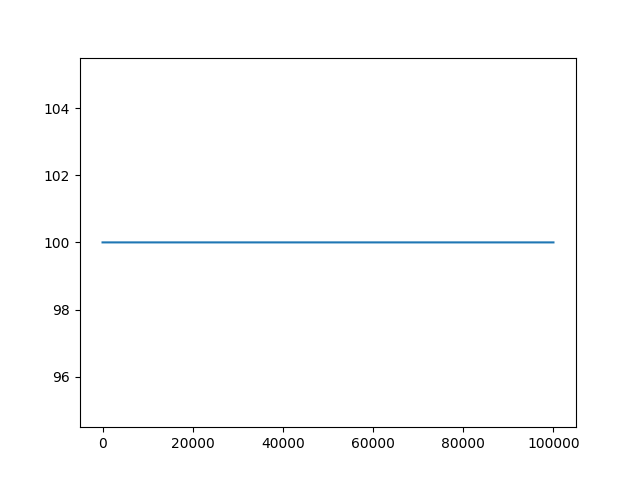

In [282]:
params = np.array([0.5])
steps = 100000
# get a chain from Metropolis
chain, acc = MetropolisWalker(params, steps, dt=0.9, subgroup_size=11)

# get energies for each step
energies = np.zeros(steps)
for i in range(steps):
    energies[i] = LocalEnergy(chain[i,:,:], params)

# plot the energies
plt.figure()
plt.plot(energies)
# print acc
print(acc)


In [283]:
@njit
def DynamicWalker(params, walker, steps, batch_size, start_dt, start_subgroup_size):
    
    dt = start_dt
    subgroup_size = start_subgroup_size

    accs = np.zeros(steps//batch_size)
    dts = np.zeros(steps//batch_size)
    SGsizes = np.zeros(steps//batch_size)
    chain = np.zeros((steps, N, D))
    
    for i in range(steps//batch_size):
        batch_chain, acc = walker(params, batch_size, dt, subgroup_size)
        # random update or the dt or the subgroup size
        if np.random.random() < 0.5:
            if acc < 0.2:
                dt *= 0.9
            if acc > 0.5:
                dt *= 1.1
        else:
            if acc < 0.2:
                subgroup_size = int(subgroup_size*0.9)
                # if equal to zero, set to 1
                if subgroup_size == 0:
                    subgroup_size = 1
            if acc > 0.5:
                subgroup_size = int(subgroup_size*1.1+0.5)
                if subgroup_size > N:
                    subgroup_size = N

        chain[i*batch_size:(i+1)*batch_size] = batch_chain
        accs[i] = acc
        dts[i] = dt
        SGsizes[i] = subgroup_size

    return chain, accs, dts, SGsizes


In [284]:
# get a chain from Metropolis with DynamicWalker
chain, accs, dts, SGsizes = DynamicWalker(params, MetropolisWalker, steps, batch_size=1000, start_dt=10, start_subgroup_size=100)

In [285]:
dts

array([10.        ,  9.        ,  9.        ,  8.1       ,  8.1       ,
        8.1       ,  8.1       ,  8.1       ,  7.29      ,  6.561     ,
        5.9049    ,  5.31441   ,  5.31441   ,  5.31441   ,  5.31441   ,
        4.782969  ,  4.782969  ,  4.782969  ,  4.782969  ,  4.782969  ,
        4.3046721 ,  4.3046721 ,  4.3046721 ,  3.87420489,  3.87420489,
        3.87420489,  3.87420489,  3.4867844 ,  3.13810596,  3.13810596,
        2.82429536,  2.82429536,  2.82429536,  2.82429536,  2.82429536,
        2.54186583,  2.28767925,  2.05891132,  2.05891132,  2.05891132,
        2.05891132,  2.05891132,  2.05891132,  2.05891132,  2.05891132,
        2.05891132,  2.05891132,  2.05891132,  2.05891132,  2.05891132,
        2.05891132,  2.05891132,  2.05891132,  2.05891132,  2.05891132,
        2.05891132,  2.05891132,  2.05891132,  2.05891132,  2.05891132,
        2.05891132,  2.05891132,  2.05891132,  2.05891132,  2.05891132,
        2.05891132,  2.05891132,  2.05891132,  2.05891132,  2.05

In [286]:
SGsizes

array([90., 90., 81., 81., 72., 64., 57., 51., 51., 51., 51., 51., 45.,
       40., 36., 36., 32., 28., 25., 22., 22., 19., 17., 17., 15., 13.,
       11., 11., 11.,  9.,  9.,  8.,  7.,  6.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.])

In [287]:
accs

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.001, 0.005,
       0.009, 0.013, 0.037, 0.026, 0.036, 0.074, 0.092, 0.082, 0.126,
       0.179, 0.191, 0.242, 0.211, 0.212, 0.2  , 0.22 , 0.23 , 0.222,
       0.241, 0.238, 0.229, 0.217, 0.228, 0.259, 0.231, 0.225, 0.213,
       0.218, 0.214, 0.246, 0.23 , 0.213, 0.211, 0.243, 0.238, 0.231,
       0.244, 0.216, 0.225, 0.241, 0.241, 0.249, 0.224, 0.249, 0.224,
       0.213, 0.235, 0.217, 0.235, 0.223, 0.242, 0.236, 0.243, 0.229,
       0.218, 0.211, 0.207, 0.221, 0.246, 0.221, 0.254, 0.239, 0.237,
       0.231, 0.234, 0.207, 0.257, 0.211, 0.232, 0.222, 0.205, 0.209,
       0.249])

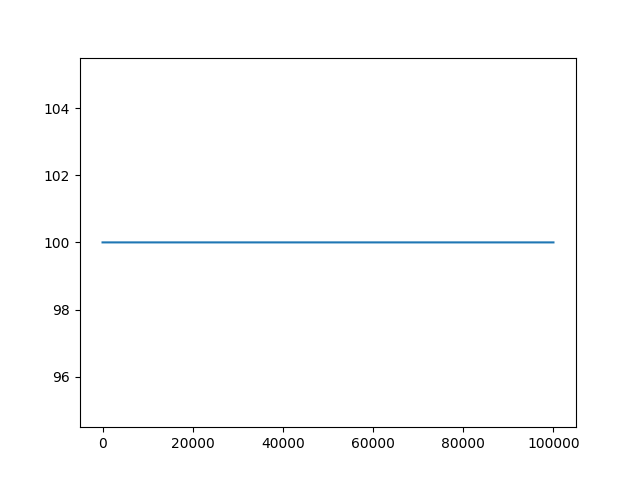

In [288]:
# plot energies from chain
energies = np.zeros(steps)
for i in range(steps):
    energies[i] = LocalEnergy(chain[i,:,:], params)

plt.figure()
plt.plot(energies)

0.40224


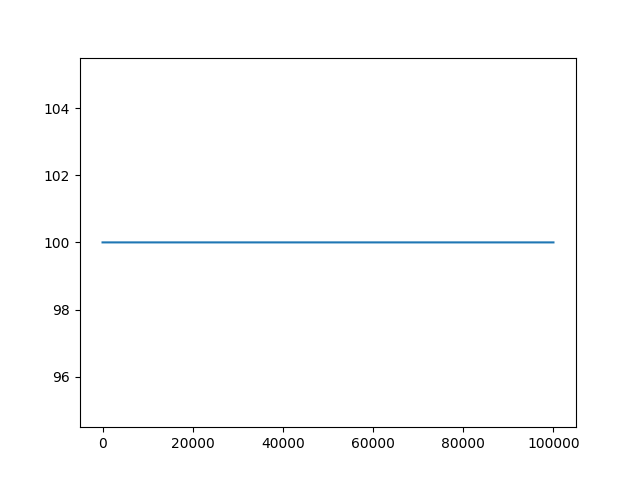

In [289]:
# get a chain with inital conf euqal to last position of dynamic chain

chain, acc = MetropolisWalker(params, steps, dt=0.9, subgroup_size=11, init_conf=chain[-1,:,:])

# plot energies from chain
energies = np.zeros(steps)
for i in range(steps):
    energies[i] = LocalEnergy(chain[i,:,:], params)

plt.figure()
plt.plot(energies)
print(acc)

/home/luigi/anaconda3/envs/sci/lib/python3.10/site-packages/matplotlib/axes/_base.py:2141: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


<ErrorbarContainer object of 3 artists>

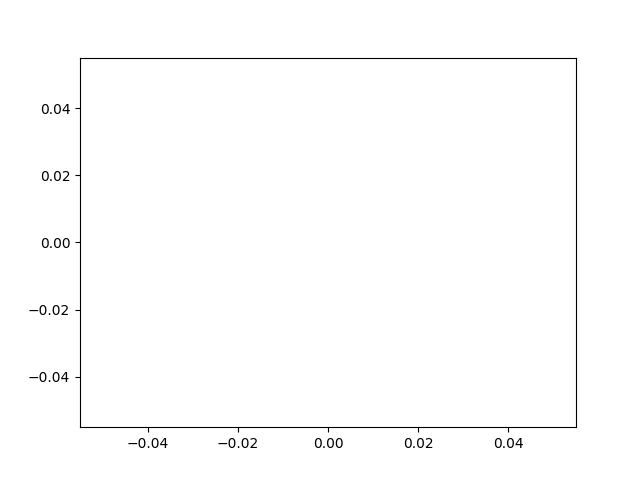

In [290]:
# get autocorrelation coefficient
C_tau, C_tau_err = AutocorrCoeff(energies)

# plot
plt.figure()
plt.errorbar(np.arange(len(C_tau)), C_tau, yerr=C_tau_err)

ValueError: array must not contain infs or NaNs

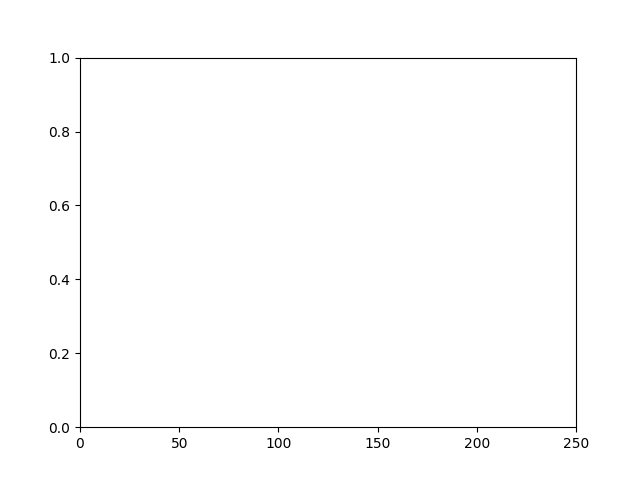

In [291]:
# plot erro
plt.figure()
plt.errorbar(range(len(C_tau)), C_tau, yerr=C_tau_err)
plt.xlim(0,250)
plt.ylim(0,1)

# fit exp(-t/tau) to the autocorrelation coefficient
from scipy.optimize import curve_fit

def exp_fit(t, tau):
    return np.exp(-t/tau)

# fit only :250
popt, pcov = curve_fit(exp_fit, np.arange(0,250), C_tau[:250])

# plot fit
plt.plot(exp_fit(np.arange(0,250), popt[0]))

# print tau and err
print(popt[0], pcov[0,0]**0.5)


In [ ]:
# use the blocking alogrithm to get the error on energy
# blocm transfor X: x1, x2, x3 ... -> X': (x1+x2)/2, (x3+x4)/2, 

@njit
def block_transform(X):
    X_prime = np.zeros(len(X)//2)
    for i in range(len(X)//2):
        X_prime[i] = 0.5*(X[2*i] + X[2*i+1])
    return X_prime

@njit
def block_error(X):
    X_prime = block_transform(X)
    return np.std(X_prime)/sqrt(len(X_prime))

# define a function that interativly block transform and get the error unitl X' is size 2
@njit
def block_error_iter(X):
    X_prime = X
    errors = []
    while len(X_prime) > 2:
        errors.append(block_error(X_prime))
        X_prime = block_transform(X_prime)
    return errors




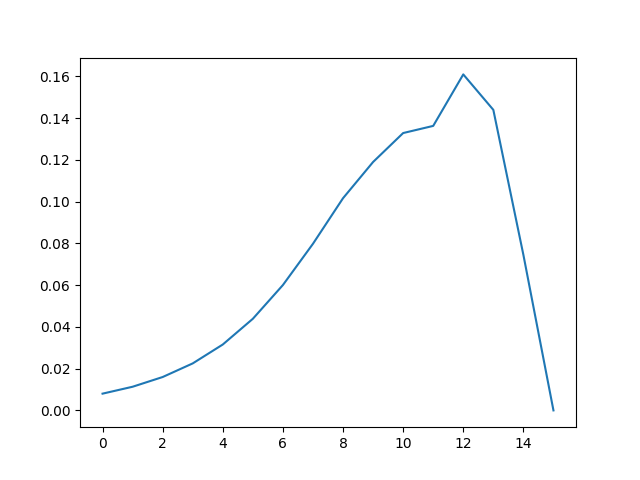

In [ ]:
# get the error on the energy
errors = block_error_iter(energies)

# plot the error
plt.figure()
plt.plot(errors)

In [ ]:
# get a chain from Metropolis with DynamicWalker
chain, accs, dts, SGsizes = DynamicWalker(params, MetropolisWalker, steps, batch_size=1000, start_dt=0.1, start_subgroup_size=10)

In [ ]:
accs

array([0.9  , 0.893, 0.881, 0.871, 0.861, 0.85 , 0.823, 0.812, 0.804,
       0.794, 0.816, 0.777, 0.791, 0.773, 0.742, 0.711, 0.702, 0.689,
       0.667, 0.665, 0.597, 0.592, 0.597, 0.546, 0.536, 0.504, 0.474,
       0.488, 0.503, 0.448, 0.419, 0.418, 0.443, 0.416, 0.408, 0.431,
       0.434, 0.441, 0.468, 0.44 , 0.42 , 0.422, 0.437, 0.443, 0.44 ,
       0.451, 0.44 , 0.465, 0.453, 0.446, 0.435, 0.452, 0.425, 0.453,
       0.441, 0.442, 0.451, 0.432, 0.424, 0.41 , 0.427, 0.412, 0.443,
       0.418, 0.444, 0.423, 0.437, 0.447, 0.42 , 0.416, 0.429, 0.466,
       0.433, 0.459, 0.456, 0.434, 0.45 , 0.46 , 0.447, 0.46 , 0.452,
       0.45 , 0.436, 0.407, 0.457, 0.454, 0.431, 0.475, 0.426, 0.44 ,
       0.431, 0.433, 0.421, 0.456, 0.413, 0.439, 0.448, 0.44 , 0.444,
       0.437])

In [ ]:
dts

array([0.11      , 0.121     , 0.121     , 0.1331    , 0.14641   ,
       0.161051  , 0.1771561 , 0.19487171, 0.19487171, 0.21435888,
       0.21435888, 0.21435888, 0.21435888, 0.23579477, 0.25937425,
       0.28531167, 0.28531167, 0.31384284, 0.34522712, 0.37974983,
       0.37974983, 0.37974983, 0.37974983, 0.41772482, 0.4594973 ,
       0.50544703, 0.50544703, 0.50544703, 0.55599173, 0.55599173,
       0.55599173, 0.55599173, 0.55599173, 0.55599173, 0.55599173,
       0.55599173, 0.55599173, 0.55599173, 0.55599173, 0.55599173,
       0.55599173, 0.55599173, 0.55599173, 0.55599173, 0.55599173,
       0.55599173, 0.55599173, 0.55599173, 0.55599173, 0.55599173,
       0.55599173, 0.55599173, 0.55599173, 0.55599173, 0.55599173,
       0.55599173, 0.55599173, 0.55599173, 0.55599173, 0.55599173,
       0.55599173, 0.55599173, 0.55599173, 0.55599173, 0.55599173,
       0.55599173, 0.55599173, 0.55599173, 0.55599173, 0.55599173,
       0.55599173, 0.55599173, 0.55599173, 0.55599173, 0.55599

In [ ]:
SGsizes

array([10., 10., 11., 11., 11., 11., 11., 11., 12., 12., 13., 14., 15.,
       15., 15., 15., 17., 17., 17., 17., 19., 21., 23., 23., 23., 23.,
       23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23.,
       23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23.,
       23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23.,
       23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23.,
       23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23.,
       23., 23., 23., 23., 23., 23., 23., 23., 23.])

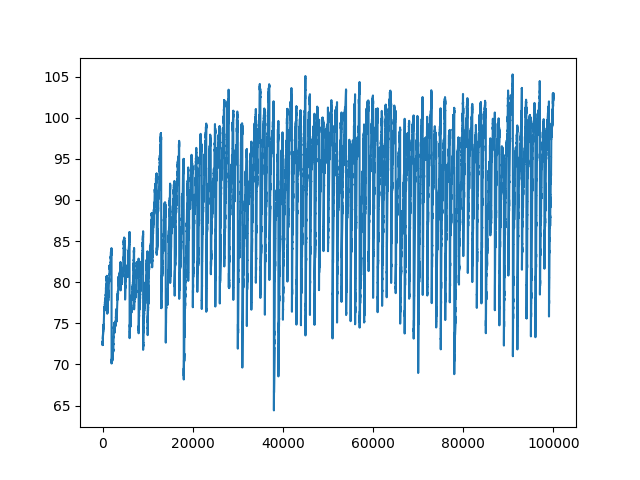

In [ ]:
# plot energies from chain
energies = np.zeros(steps)
for i in range(steps):
    energies[i] = LocalEnergy(chain[i,:,:], params)

plt.figure()
plt.plot(energies)

0.54498


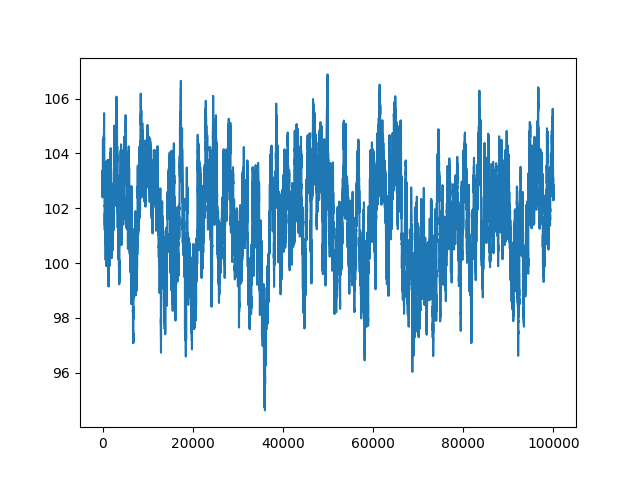

In [ ]:
# get a chain with inital conf euqal to last position of dynamic chain

chain, acc = MetropolisWalker(params, steps, dt=0.37, subgroup_size=31, init_conf=chain[-1,:,:])

# plot energies from chain
energies = np.zeros(steps)
for i in range(steps):
    energies[i] = LocalEnergy(chain[i,:,:], params)

plt.figure()
plt.plot(energies)
print(acc)

<ErrorbarContainer object of 3 artists>

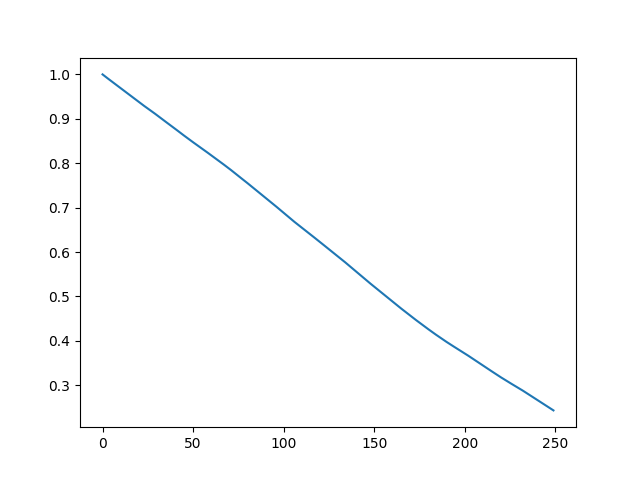

In [ ]:
# get autocorrelation coefficient
C_tau, C_tau_err = AutocorrCoeff(energies)

# plot
plt.figure()
plt.errorbar(np.arange(len(C_tau)), C_tau, yerr=C_tau_err)

223.07395729825566 2.0657170874876445


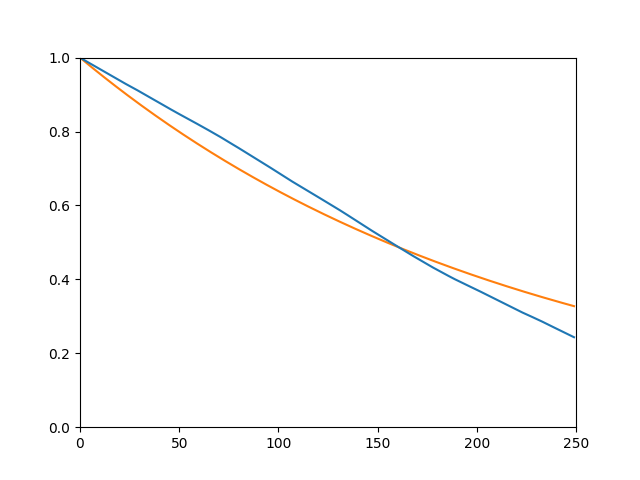

In [ ]:
# plot erro
plt.figure()
plt.errorbar(range(len(C_tau)), C_tau, yerr=C_tau_err)
plt.xlim(0,250)
plt.ylim(0,1)

# fit exp(-t/tau) to the autocorrelation coefficient
from scipy.optimize import curve_fit

def exp_fit(t, tau):
    return np.exp(-t/tau)

# fit only :250
popt, pcov = curve_fit(exp_fit, np.arange(0,250), C_tau[:250])

# plot fit
plt.plot(exp_fit(np.arange(0,250), popt[0]))

# print tau and err
print(popt[0], pcov[0,0]**0.5)


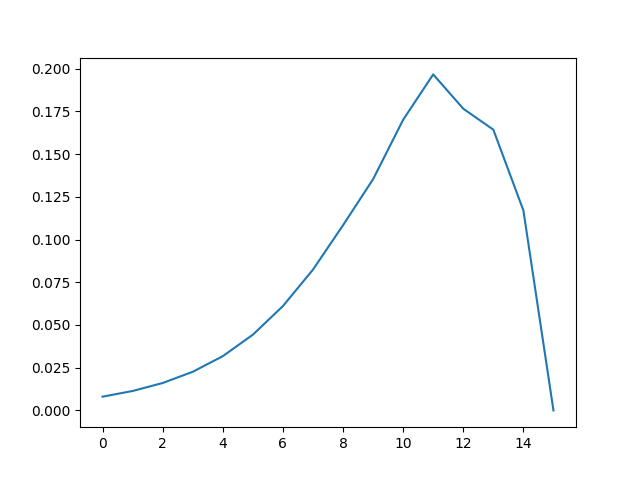

In [ ]:
# get the error on the energy
errors = block_error_iter(energies)

# plot the error
plt.figure()
plt.plot(errors)

In [ ]:
# def a function that start from init_dt and init_subgroup_size, make DynamicWalk, then plot the energies,
# then start a Walker with initial condition the last of Dynamic, then plot the energies, then get the autocorrelation and plot coefficient until :250,
# fit the exp(-t/tau) to the autocorrelation coefficient, then get the error on the energy with block_error_iter, then plot the error

def HyperWalker(params, init_dt, init_subgroup_size, steps, batch_size):
    dyn_chain, accs, dts, SGsizes = DynamicWalker(params, MetropolisWalker, steps, batch_size=batch_size, start_dt=init_dt, start_subgroup_size=init_subgroup_size)
    
    energies = np.zeros(steps)
    for i in range(steps):
        energies[i] = LocalEnergy(dyn_chain[i,:,:], params)
    
    plt.figure()
    plt.plot(energies)
    plt.title("DynamicWalker")
    plt.xlabel("Steps")
    plt.ylabel("Energy")
    # print the last parameters, dts, SGsizes
    print("Last dt: ", dts[-1], "Last SGsize: ", SGsizes[-1], "Last acc: ", accs[-1])
    chain, acc = MetropolisWalker(params, steps, dt=dts[-1], subgroup_size=int(SGsizes[-1]), init_conf=dyn_chain[-1,:,:])
    
    energies = np.zeros(steps)
    for i in range(steps):
        energies[i] = LocalEnergy(chain[i,:,:], params)
    
    plt.figure()
    plt.plot(energies)
    plt.title("MetropolisWalker")
    plt.xlabel("Steps")
    plt.ylabel("Energy")
    
    C_tau, C_tau_err = AutocorrCoeff(energies)
    
    plt.figure()
    plt.errorbar(np.arange(len(C_tau)), C_tau, yerr=C_tau_err)
    plt.title("Autocorrelation Coefficient")
    plt.xlabel("Tau")
    plt.ylabel("C(tau)")
    
    popt, pcov = curve_fit(exp_fit, np.arange(0,250), C_tau[:250])
    
    plt.plot(exp_fit(np.arange(0,250), popt[0]))
    plt.xlim(0,250)
    plt.ylim(0,1)
    # print the fit results
    print("Tau: ", popt[0], "Error: ", pcov[0,0]**0.5)
    
    errors = block_error_iter(energies)
    
    plt.figure()
    plt.plot(errors[:-1])
    plt.title("Energy Error")
    plt.xlabel("Block")
    plt.ylabel("Error")

Last dt:  4.830798690000001 Last SGsize:  1.0 Last acc:  0.247
Tau:  884.7193037011447 Error:  2.1877142489533252


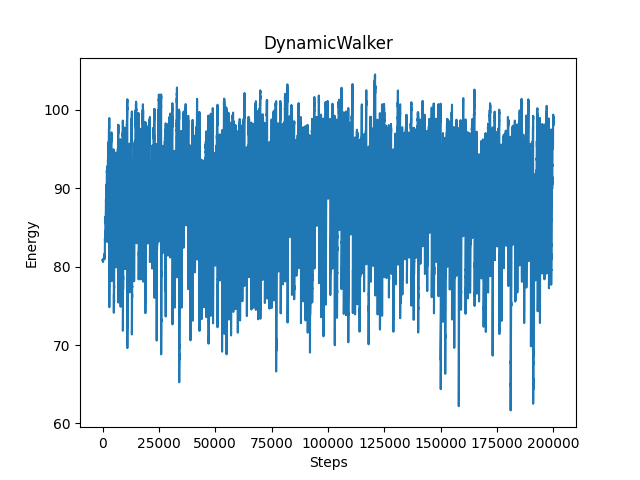

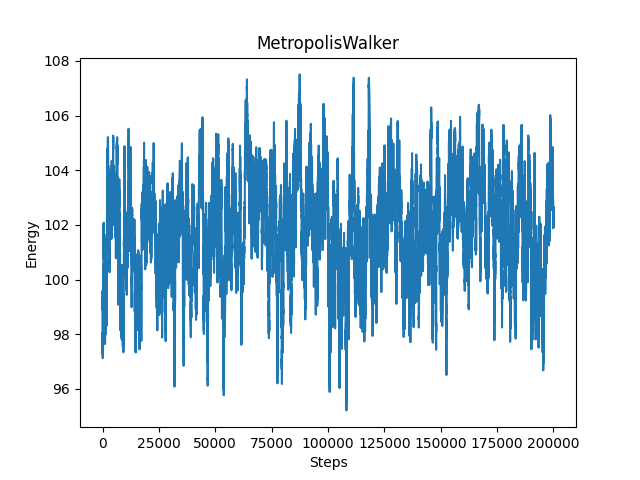

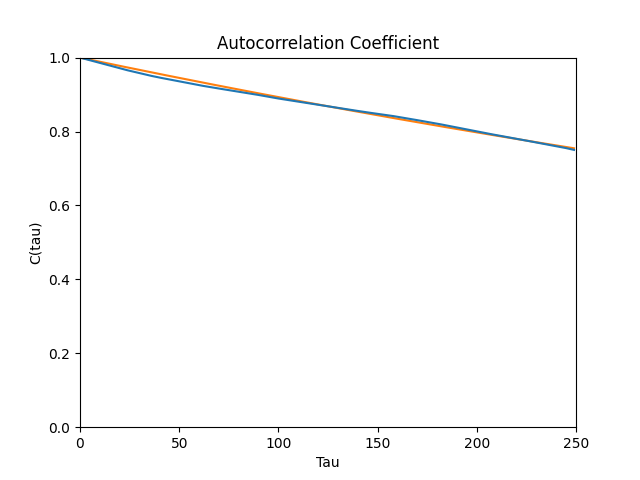

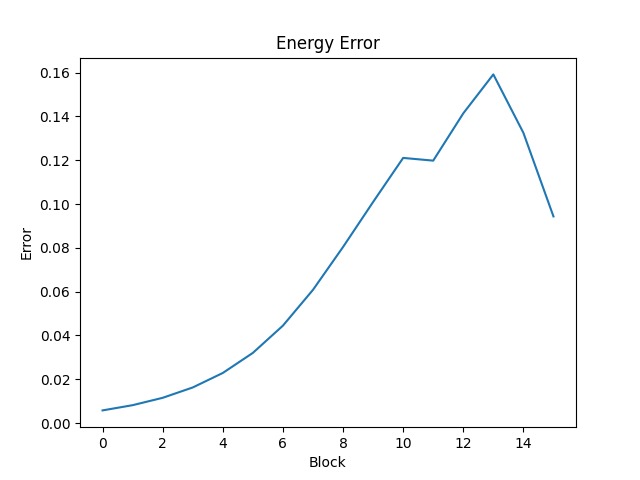

In [ ]:
# run the HyperWalker
HyperWalker(params, init_dt=10.1, init_subgroup_size=2, steps=200000, batch_size=1000)

Last dt:  0.3138428376721002 Last SGsize:  100.0 Last acc:  0.43
Tau:  426.10972820711714 Error:  0.6692079198530656


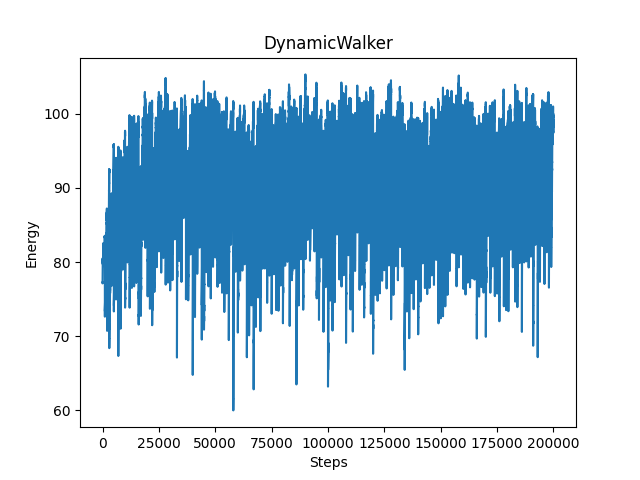

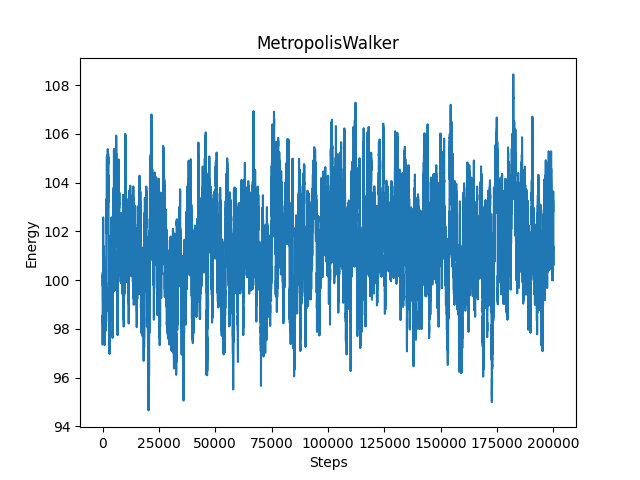

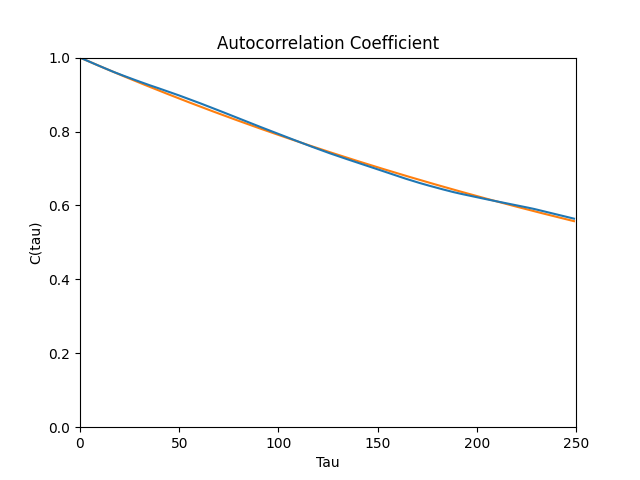

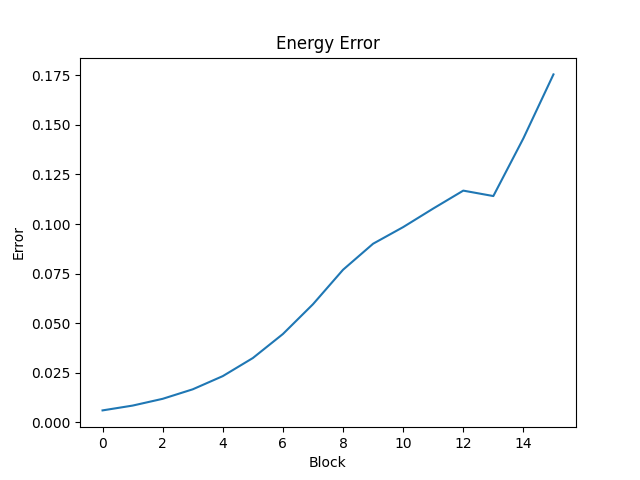

In [ ]:
HyperWalker(params, init_dt=0.1, init_subgroup_size=80, steps=200000, batch_size=1000)

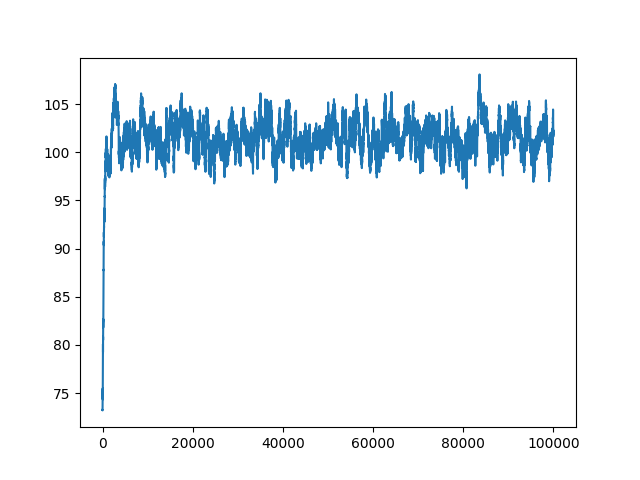

In [ ]:
# get a chain with dt = 0.25, subgroup_size = 90
chain, acc = MetropolisWalker(params, steps, dt=0.25, subgroup_size=90)

# plot energies from chain
energies = np.zeros(steps)
for i in range(steps):
    energies[i] = LocalEnergy(chain[i,:,:], params)

plt.figure()
plt.plot(energies)

In [ ]:
# get the mean and the error on the energy 20000:
mean = np.mean(energies[20000:])
error = np.std(energies[20000:])/sqrt(len(energies[20000:]))

print(mean, error)

101.5150935801815 0.005812448856780928
